In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [38]:
df = pd.read_csv('temperature_data.csv')

In [39]:
df.head()

,city,timestamp,temperature,season
0,New York,2010-01-01,-5.708643,winter
1,New York,2010-01-02,9.719531,winter
2,New York,2010-01-03,-5.446145,winter
3,New York,2010-01-04,-0.787049,winter
4,New York,2010-01-05,-2.969704,winter


### 1. Разведочный анализ данных. Вычисление скользящего среднего. Визуализация.

Для начала оценим среднюю температуру за анализируемый период. Это позволит нам понять, есть ли тенденция к росту средней температуры и подойдет ли средняя температура и ее стандартное отклонение для анализа аномалий

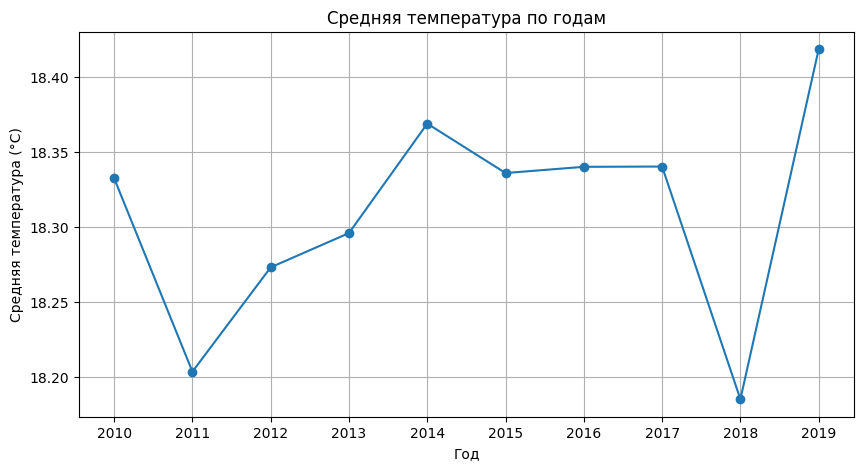

In [40]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

df['year'] = df['timestamp'].dt.year

annual_mean = df.groupby('year')['temperature'].mean().reset_index()

plt.figure(figsize=(10, 5))
plt.plot(annual_mean['year'], annual_mean['temperature'], marker='o')
plt.title('Средняя температура по годам')
plt.xlabel('Год')
plt.ylabel('Средняя температура (°C)')
plt.grid()
plt.xticks(annual_mean['year']) 
plt.show()

В целом можно сказать, что какого-то яроко выраженного тренда на рост или снижение температуры нет. Поэтому для последующего исследования при выявлении выбросов будем ориентироваться на средние температуры и стандартные отклонения, расчитанные для каждого города и сезона.

In [41]:
mean_std = df.groupby(['city', 'season'])['temperature'].agg(['mean', 'std']).reset_index()

In [42]:
mean_std.head(7)

,city,season,mean,std
0,Beijing,autumn,15.887874,4.994010
1,Beijing,spring,12.972876,5.023080
2,Beijing,summer,26.919439,4.802112
3,Beijing,winter,-1.931907,5.080286
4,Berlin,autumn,11.017517,4.964859
5,Berlin,spring,10.229643,4.972362
6,Berlin,summer,20.305067,4.940060


Определеим выбросы исходя из отклонения 2 и 3 сигмы от средней температуры по сезону

In [43]:
df = df.merge(mean_std, on=['city', 'season']) # для оценки аномалий возпользуемся сигмой из предыдущего шага

Осуществим распараллеливание расчетов и оценим скорость вычислений с применением распараллеливания и без. Будем использовать библиотеку joblib, которая хорошо адаптирована для работы с Jupyter Notebook

In [44]:
%%time
# Посмотрим на отклонение от средней тепературы за сезон на 2 сигмы 
df['is_outlier_2s'] = (df['temperature'] > (df['mean'] + 2 * df['std'])) | \
                (df['temperature'] < (df['mean'] - 2 * df['std']))

CPU times: user 1.41 ms, sys: 1.07 ms, total: 2.48 ms
Wall time: 1.78 ms


In [45]:
%%time
# Осуществим распараллеливание расчетов 
from joblib import Parallel, delayed

upper_bound = df['mean'] + 2 * df['std']
lower_bound = df['mean'] - 2 * df['std']

def compute_outliers_2s(temp, upper_bound, lower_bound):
    return (temp > upper_bound) | (temp < lower_bound)

df['is_outlier_2s_parallel'] = Parallel(n_jobs=-1)(
    delayed(compute_outliers_2s)(
        temp,
        row.mean + 2 * row.std,
        row.mean - 2 * row.std
    ) for temp, row in zip(df['temperature'], df.itertuples(index=False))
)

CPU times: user 240 ms, sys: 29.5 ms, total: 269 ms
Wall time: 284 ms


Как видно, параллельное вычисление происходит медленнее. Думаю что дело в высоком уровне оптимизации операций в Pandas, которые позволяют выполнять векторные расчеты быстрее многопоточных.

In [46]:
outliers_2s = df[df['is_outlier_2s'] == True]
outliers_2s.head()

,city,timestamp,temperature,season,year,mean,std,is_outlier_2s,is_outlier_2s_parallel
14,New York,2010-01-15,-17.375875,winter,2010,-0.054833,5.135903,True,True
31,New York,2010-02-01,-15.380372,winter,2010,-0.054833,5.135903,True,True
65,New York,2010-03-07,20.431652,spring,2010,9.995782,5.107322,True,True
127,New York,2010-05-08,-0.831938,spring,2010,9.995782,5.107322,True,True
152,New York,2010-06-02,38.552919,summer,2010,24.929997,4.866523,True,True


In [47]:
outliers_2s.shape

(2462, 9)

Всего получилось 2 462 наблюдений, которые более чем на 2 стандартных отклонения отличаются от годовой температуры, т.е. порядка 5% от выборки, что является невысоким показателем.

Проведем анализ скорости работы при распараллеливании вычисления выбросок за диапазоном 3х сигм

In [48]:
%%time
# Последовательное выполнение
df['is_outlier_3s'] = (df['temperature'] > (df['mean'] + 3 * df['std'])) | \
                (df['temperature'] < (df['mean'] - 3 * df['std']))

CPU times: user 1.06 ms, sys: 652 μs, total: 1.71 ms
Wall time: 1.11 ms


In [49]:
%%time
# Параллельное выполнение
from joblib import Parallel, delayed

upper_bound = df['mean'] + 3 * df['std']
lower_bound = df['mean'] - 3 * df['std']

def compute_outliers_3s(temp, upper_bound, lower_bound):
    return (temp > upper_bound) | (temp < lower_bound)

df['is_outlier_3s_parallel'] = Parallel(n_jobs=-1)(
    delayed(compute_outliers_3s)(
        temp,
        row.mean + 3 * row.std,
        row.mean - 3 * row.std
    ) for temp, row in zip(df['temperature'], df.itertuples(index=False))
)

CPU times: user 202 ms, sys: 8.53 ms, total: 210 ms
Wall time: 223 ms


Аналогично ранее выполненным расчетам, многопоточный векторные операции показали лучшее время выполнения, чем многопоточные, в связи с чем для оценки выбросов будем использовать расчеты без многопточности.

In [50]:
outliers_3s = df[df['is_outlier_3s'] == True]
outliers_3s.head()

,city,timestamp,temperature,season,year,mean,std,is_outlier_2s,is_outlier_2s_parallel,is_outlier_3s,is_outlier_3s_parallel
14,New York,2010-01-15,-17.375875,winter,2010,-0.054833,5.135903,True,True,True,True
429,New York,2011-03-06,-9.353832,spring,2011,9.995782,5.107322,True,True,True,True
609,New York,2011-09-02,0.178981,autumn,2011,15.247775,4.920612,True,True,True,True
626,New York,2011-09-19,33.217546,autumn,2011,15.247775,4.920612,True,True,True,True
1109,New York,2013-01-14,19.136698,winter,2013,-0.054833,5.135903,True,True,True,True


In [51]:
outliers_3s.shape

(151, 11)

Отклонений более чем на 3 сигмы всего 151, что менее 0.3% выборки. Ознакомимся с наибольшими и наименьшими значениями температуры.

In [52]:
sorted_outliers = outliers_3s.sort_values(by='temperature', ascending=False)

In [53]:
sorted_outliers.head(10)

,city,timestamp,temperature,season,year,mean,std,is_outlier_2s,is_outlier_2s_parallel,is_outlier_3s,is_outlier_3s_parallel
36378,Dubai,2019-08-30,58.228766,summer,2019,39.978481,5.075439,True,True,True,True
45126,Mumbai,2013-08-19,53.946290,summer,2013,35.173616,5.019947,True,True,True,True
49806,Cairo,2016-06-14,53.726259,summer,2016,35.079977,4.877007,True,True,True,True
47263,Mumbai,2019-06-26,51.931987,summer,2019,35.173616,5.019947,True,True,True,True
50948,Cairo,2019-07-31,51.202380,summer,2019,35.079977,4.877007,True,True,True,True
44039,Mumbai,2010-08-28,51.133058,summer,2010,35.173616,5.019947,True,True,True,True
32974,Dubai,2010-05-05,48.573560,spring,2010,29.853539,5.017651,True,True,True,True
35716,Dubai,2017-11-06,46.914897,autumn,2017,30.232503,4.877730,True,True,True,True
30153,Rio de Janeiro,2012-08-11,46.149408,summer,2012,30.017170,5.095241,True,True,True,True
44446,Mumbai,2011-10-09,45.948949,autumn,2011,29.628936,4.965633,True,True,True,True


Высокая температура наблюдается в основном в летний сезон в городах, приближенных к экваториальному поясу (Дубай, Мумбаи, Каир). Однако в результате анализа данных открытых источников можно убедиться, что данные значения являются нетипичными для указанных городов:  
- абсолютный максимум в Дубаи - 49 градусов (в нашем датасете 58)
- абсолютный максимум в Мумбаи - 32 градуса (в датасете 54)
- абсолютный максимум в Каире - 47 градусов (в датасете 54)
- абсолютный максимум в Рио-де-Жанейро - 43 градусов (в датасете 46)

По всей видимости указанные значения являются ошибочными. Возможно либо были неправиль установлены датчики температуры, либо имела место техническая проблема оборудования.

In [54]:
sorted_outliers.tail(10)

,city,timestamp,temperature,season,year,mean,std,is_outlier_2s,is_outlier_2s_parallel,is_outlier_3s,is_outlier_3s_parallel
16131,Moscow,2014-03-12,-9.771217,spring,2014,5.178063,4.898464,True,True,True,True
12399,Tokyo,2013-12-20,-11.004997,winter,2013,5.734676,5.169414,True,True,True,True
5832,London,2015-12-23,-12.134312,winter,2015,5.030085,5.079098,True,True,True,True
23784,Berlin,2015-02-28,-14.738231,winter,2015,0.065802,4.805235,True,True,True,True
24061,Berlin,2015-12-02,-15.398157,winter,2015,0.065802,4.805235,True,True,True,True
25218,Berlin,2019-02-01,-15.709727,winter,2019,0.065802,4.805235,True,True,True,True
2606,New York,2017-02-19,-16.253950,winter,2017,-0.054833,5.135903,True,True,True,True
14,New York,2010-01-15,-17.375875,winter,2010,-0.054833,5.135903,True,True,True,True
27764,Beijing,2016-01-24,-18.045933,winter,2016,-1.931907,5.080286,True,True,True,True
29193,Beijing,2019-12-23,-20.031192,winter,2019,-1.931907,5.080286,True,True,True,True


Указанные температуры не превышают абсолютного миниммума (по данным открытых источников): абсолютный минимум зимой в Пекине -27,8 градусов. В Нью-Йорке -26, в Берлине -26. Тем не менее температура существенно ниже средних значений по месяцам: для Нью-Йорка средняя в феврале 1,8 градусов, в январе 0,3 градусов. Для Пекина в январе -2,8, в декабре -1.

In [55]:
mean_std[mean_std['city'] == 'Beijing']

,city,season,mean,std
0,Beijing,autumn,15.887874,4.994010
1,Beijing,spring,12.972876,5.023080
2,Beijing,summer,26.919439,4.802112
3,Beijing,winter,-1.931907,5.080286


Как видим средняя температура зимой в Пекине в датасете составляет -1,93 градуса, при этом средняя температура за весь период наблюдений -1,1. Вероятно средняя температура в датасете может быть искажена выбросами.

<Axes: >

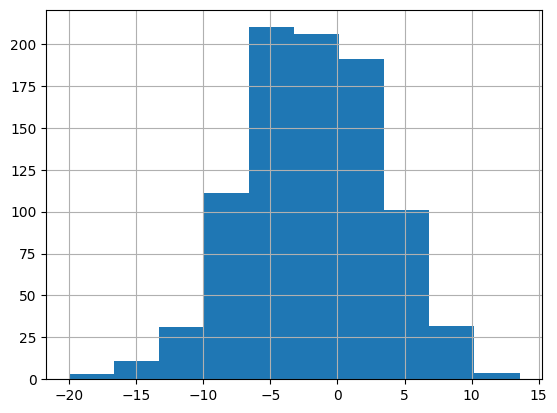

In [56]:
df[(df['city'] == 'Beijing') & (df['season'] == 'winter')]['temperature'].hist()

По распределению температуры в Пекине также видна некторая ассиметрия и наличие отрицательных выбросов.

In [57]:
df.head(20)

,city,timestamp,temperature,season,year,mean,std,is_outlier_2s,is_outlier_2s_parallel,is_outlier_3s,is_outlier_3s_parallel
0,New York,2010-01-01,-5.708643,winter,2010,-0.054833,5.135903,False,False,False,False
1,New York,2010-01-02,9.719531,winter,2010,-0.054833,5.135903,False,False,False,False
2,New York,2010-01-03,-5.446145,winter,2010,-0.054833,5.135903,False,False,False,False
3,New York,2010-01-04,-0.787049,winter,2010,-0.054833,5.135903,False,False,False,False
4,New York,2010-01-05,-2.969704,winter,2010,-0.054833,5.135903,False,False,False,False
5,New York,2010-01-06,3.223192,winter,2010,-0.054833,5.135903,False,False,False,False
6,New York,2010-01-07,-1.710828,winter,2010,-0.054833,5.135903,False,False,False,False
7,New York,2010-01-08,4.033816,winter,2010,-0.054833,5.135903,False,False,False,False
8,New York,2010-01-09,-5.178676,winter,2010,-0.054833,5.135903,False,False,False,False
9,New York,2010-01-10,-2.298772,winter,2010,-0.054833,5.135903,False,False,False,False


Для сглаживания краткосрочных колебаний расчитаем скольязщее среднее

In [58]:
df['MA'] = df['temperature'].rolling(window=30).mean()

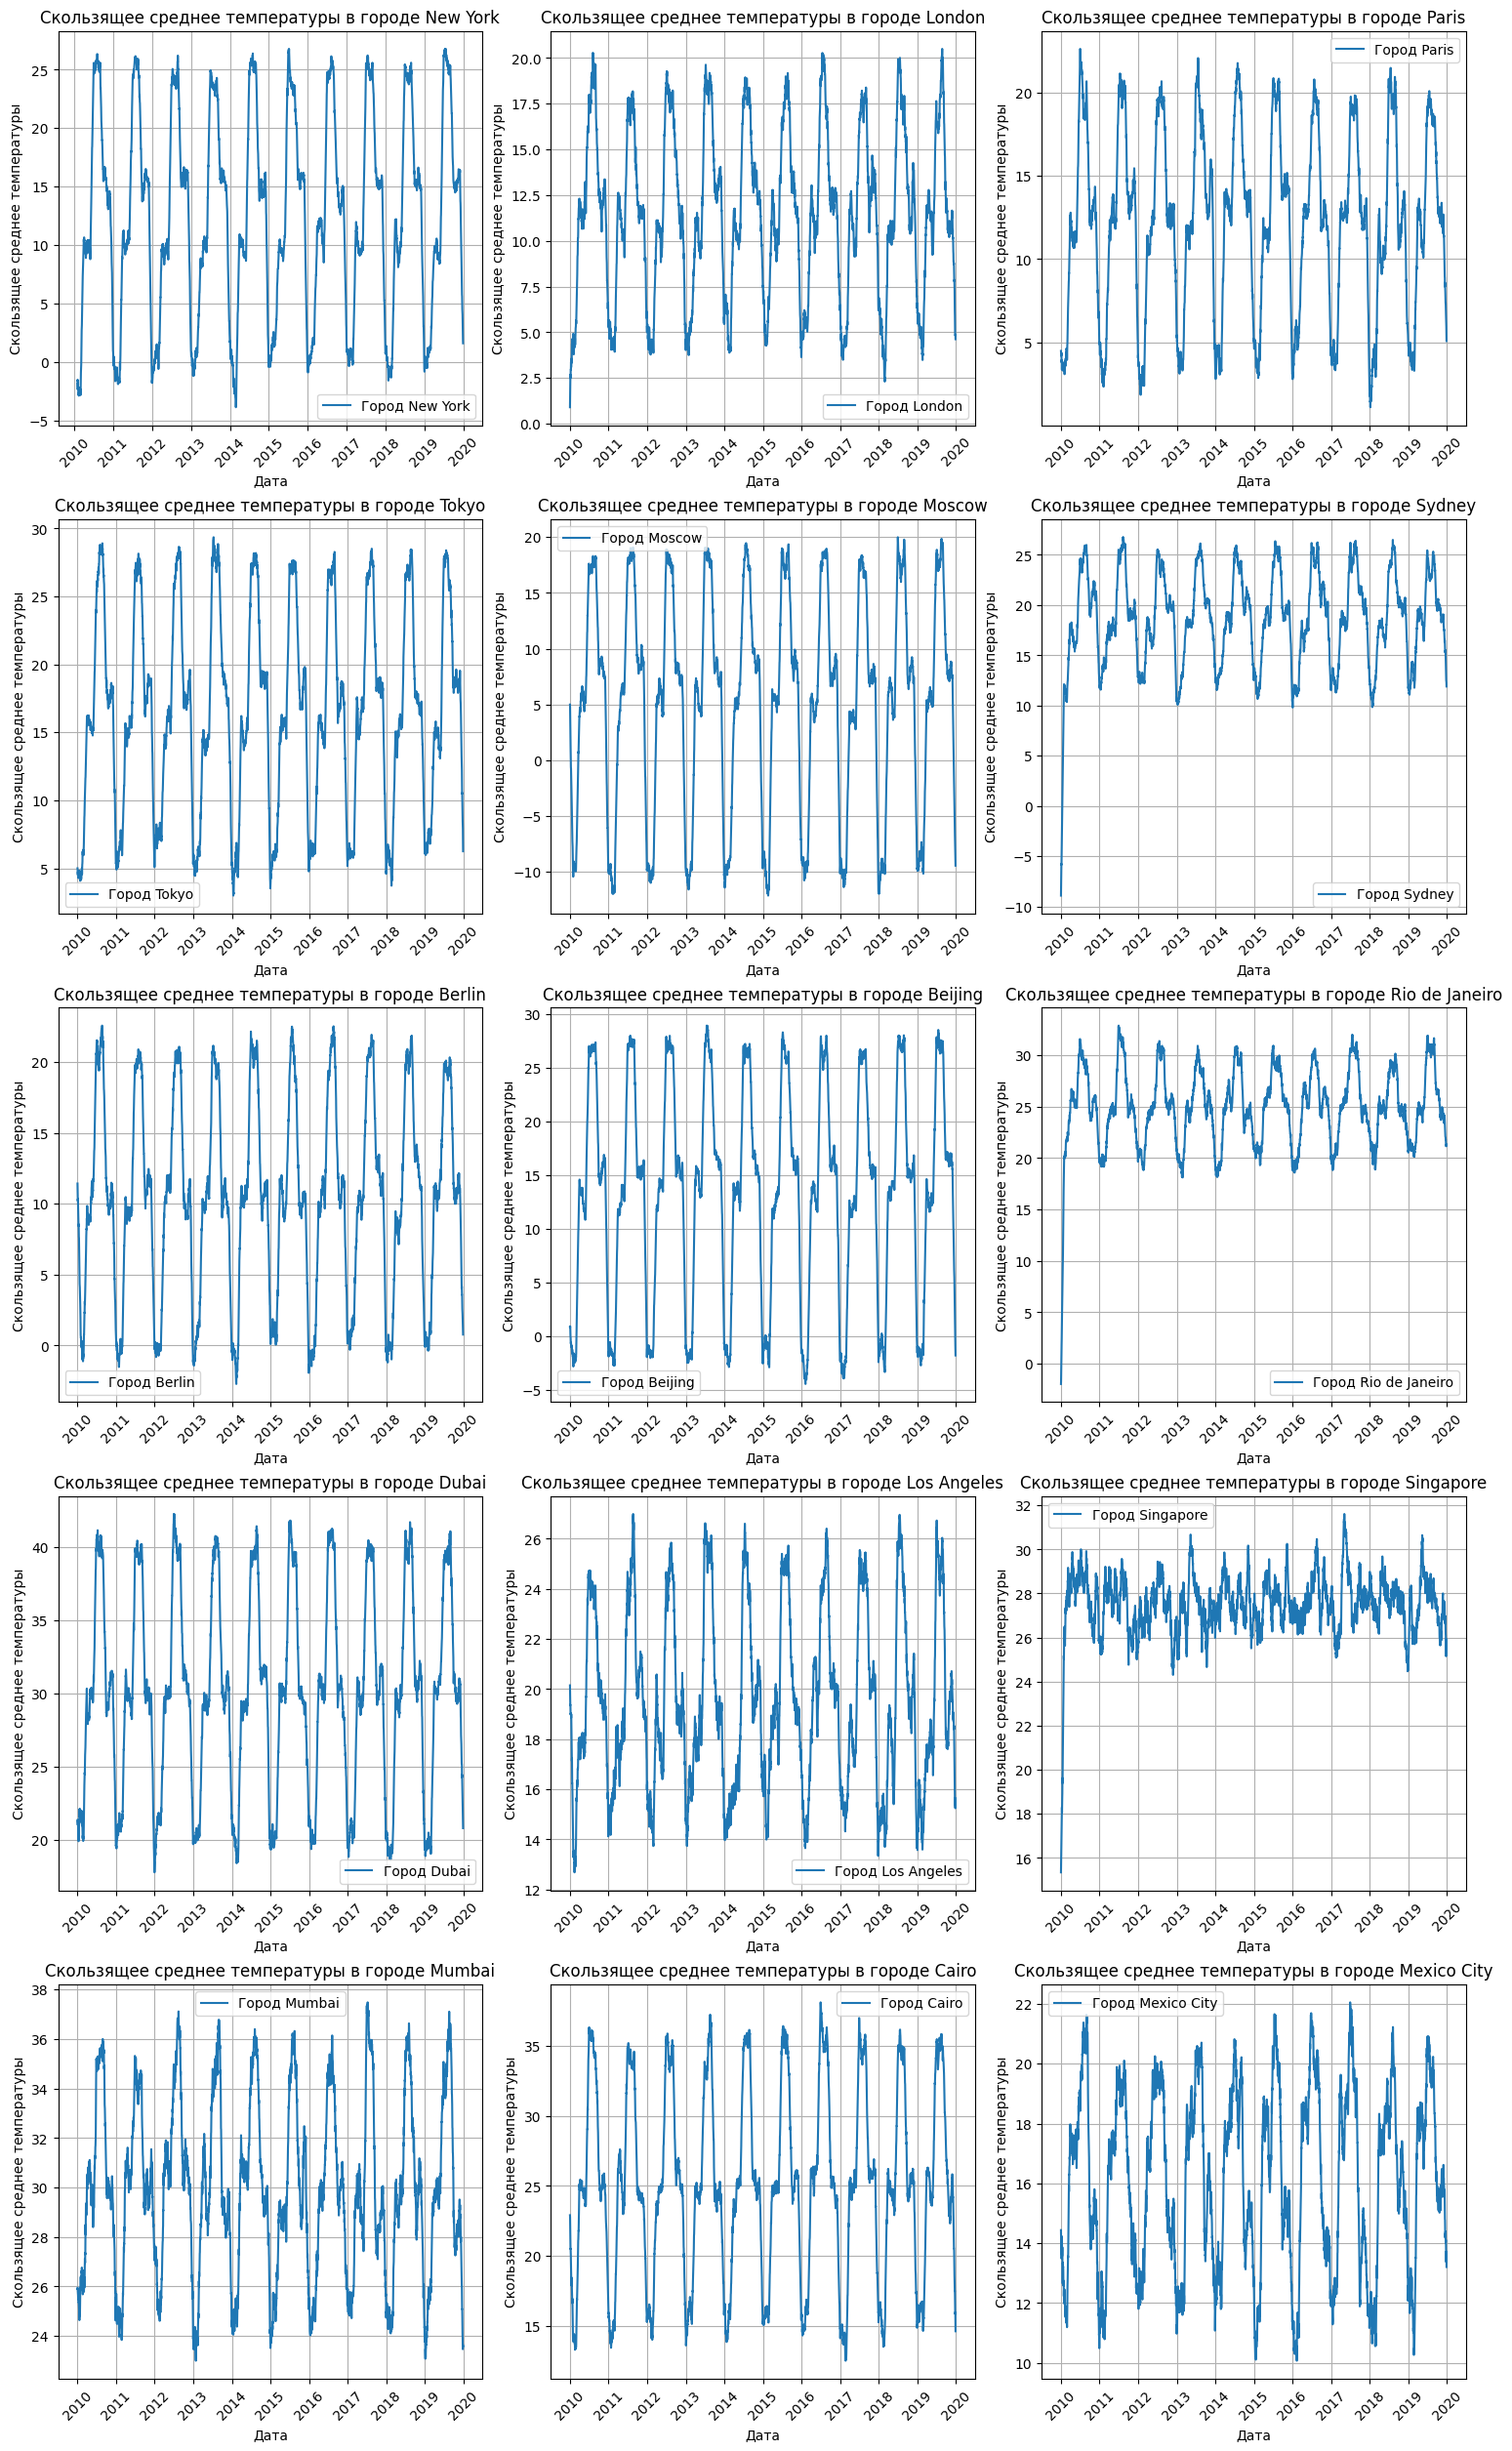

In [59]:
cities = df['city'].unique() 

num_cities = len(cities)
cols = 3 
rows = (num_cities + cols - 1) // cols  

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), constrained_layout=True)

axes = axes.flatten()

for i, city in enumerate(cities):
    city_data = df[df['city'] == city]  
    axes[i].plot(city_data['timestamp'], city_data['MA'], label=f'Город {city}')
    
    axes[i].set_title(f'Скользящее среднее температуры в городе {city}')
    axes[i].set_xlabel('Дата')
    axes[i].set_ylabel('Скользящее среднее температуры')
    axes[i].legend()
    axes[i].grid()
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

По итогам анализа графиков выявлена аномалия в данных по Сиднею, Рио-де-Жанейро, Сингапуру. Температура в январе нетипично низкая.

In [60]:
df[df['city'] == 'Sydney'].head(20)

,city,timestamp,temperature,season,year,mean,std,is_outlier_2s,is_outlier_2s_parallel,is_outlier_3s,is_outlier_3s_parallel,MA
18250,Sydney,2010-01-01,20.311336,winter,2010,12.119879,4.856804,False,False,False,False,-8.915676
18251,Sydney,2010-01-02,7.660619,winter,2010,12.119879,4.856804,False,False,False,False,-8.102824
18252,Sydney,2010-01-03,14.419136,winter,2010,12.119879,4.856804,False,False,False,False,-7.095083
18253,Sydney,2010-01-04,11.139860,winter,2010,12.119879,4.856804,False,False,False,False,-6.428670
18254,Sydney,2010-01-05,13.931563,winter,2010,12.119879,4.856804,False,False,False,False,-5.755028
18255,Sydney,2010-01-06,-3.606936,winter,2010,12.119879,4.856804,True,True,True,True,-5.845334
18256,Sydney,2010-01-07,9.024117,winter,2010,12.119879,4.856804,False,False,False,False,-5.056766
18257,Sydney,2010-01-08,16.633120,winter,2010,12.119879,4.856804,False,False,False,False,-4.106546
18258,Sydney,2010-01-09,10.497301,winter,2010,12.119879,4.856804,False,False,False,False,-3.408528
18259,Sydney,2010-01-10,11.380296,winter,2010,12.119879,4.856804,False,False,False,False,-2.909401


Удалим данные за январь для этих городов и построим графики снова. Удаление также будем распараллеливать с помощью библиотеки Joblib и замерим скорость.

In [61]:
cities_to_remove = ['Sydney', 'Singapore', 'Rio de Janeiro']

In [62]:
%%time
df_filtered_1 = df[~((df['city'].isin(cities_to_remove)) & 
                   (df['timestamp'] <= '2010-01-30'))]

CPU times: user 4.48 ms, sys: 1.63 ms, total: 6.11 ms
Wall time: 5.82 ms


In [63]:
%%time

def filter_city(row):
    return not (row['city'] in cities_to_remove and row['timestamp'] <= pd.to_datetime('2010-01-30'))

mask = Parallel(n_jobs=-1)(delayed(filter_city)(row) for index, row in df.iterrows())

df_filtered_2 = df[mask]

CPU times: user 3.36 s, sys: 93.2 ms, total: 3.45 s
Wall time: 3.58 s


При выполнении распараллеливания расчетов скорость увеличивается в 2-3 раза.

In [64]:
df = df[mask]

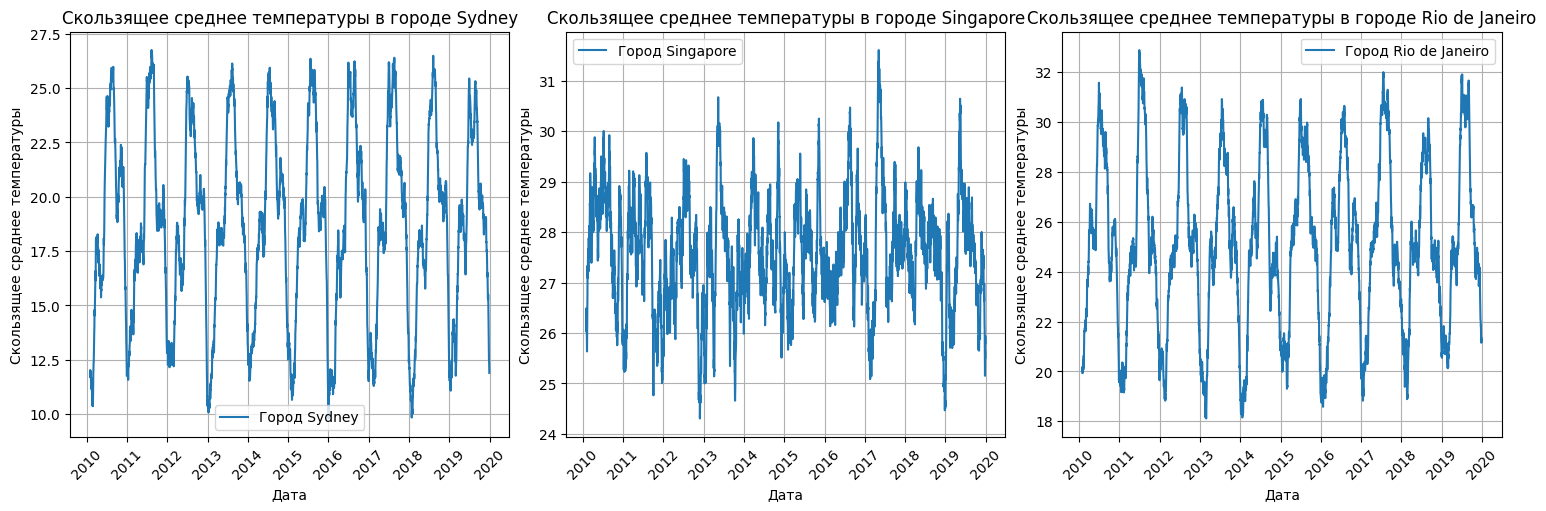

In [65]:
num_cities = len(cities_to_remove)
cols = 3 
rows = (num_cities + cols - 1) // cols  

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), constrained_layout=True)

axes = axes.flatten()

for i, city in enumerate(cities_to_remove):
    city_data = df[df['city'] == city]  
    axes[i].plot(city_data['timestamp'], city_data['MA'], label=f'Город {city}')
    
    axes[i].set_title(f'Скользящее среднее температуры в городе {city}')
    axes[i].set_xlabel('Дата')
    axes[i].set_ylabel('Скользящее среднее температуры')
    axes[i].legend()
    axes[i].grid()
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

In [66]:
def plot_with_outliers(df, city):
    filtered_df = df.query(f'city == "{city}"')

    plt.figure(figsize=(10, 5))
    plt.plot(filtered_df['timestamp'], filtered_df['temperature'], label='Температура', color='blue')

    outliers = filtered_df[filtered_df['is_outlier_2s']]
    plt.scatter(outliers['timestamp'], outliers['temperature'], color='red', label='Аномалии')

    plt.title(f'Температура в городе {city}')
    plt.xlabel('Дата')
    plt.ylabel('Температура')
    plt.legend()
    plt.grid()
    plt.show()

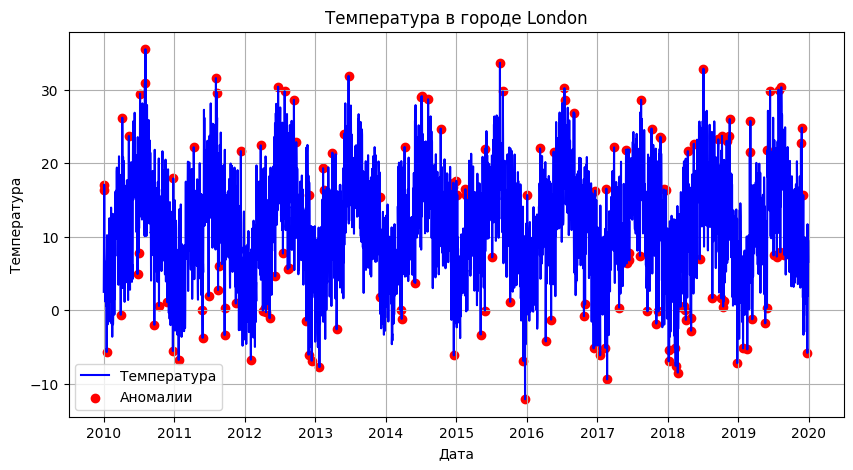

In [67]:
plot_with_outliers(df, 'London')

### 2. Запрос данных о текущей погоде

Реализуем функцию запроса данных о погоде в синхронном и асинхронном сценариях и замерим время выполнения.

In [68]:
import httpx
import json
import asyncio


def get_weather(cities, api_key):
    temperatures = {}
    for city in cities:
        try:
            with httpx.Client() as client:
                response = client.get(f'https://api.openweathermap.org/data/2.5/weather?q={city}&appid={api_key}&units=metric')
                weather_data = response.json()
                temp = weather_data['main']['temp']
                temperatures[city] = temp
        except httpx.HTTPStatusError as e:
            print(f"HTTP error occurred: {e.response.status_code} - {e.response.text}")
        except httpx.RequestError as e:
            print(f"Request error occurred: {e}")
        except Exception as e:
            print(f"An unexpected error occurred: {e}")
    return temperatures


async def get_weather_async(cities, api_key):
    temperatures = {}
    
    async with httpx.AsyncClient() as client:
        tasks = []
        
        for city in cities:
            tasks.append(client.get(f'https://api.openweathermap.org/data/2.5/weather?q={city}&appid={api_key}&units=metric'))

        try:
            responses = await asyncio.gather(*tasks)

            # выполним распараллеливание обработки резултатов запроса
            results = Parallel(n_jobs=-1)(delayed(process_response)(response) for response in responses)
            
            for city_name, temp in results:
                temperatures[city_name] = temp
                
        except httpx.HTTPStatusError as e:
            print(f"HTTP error occurred: {e.response.status_code} - {e.response.text}")
        except httpx.RequestError as e:
            print(f"Request error occurred: {e}")
        except Exception as e:
            print(f"An unexpected error occurred: {e}")

    return temperatures

def process_response(response):
    weather_data = response.json()
    temp = weather_data['main']['temp']
    city_name = weather_data['name'] 
    return city_name, temp  


In [69]:
cities = ['New York', 'London', 'Paris', 'Tokyo', 'Moscow', 'Sydney',
          'Berlin', 'Beijing', 'Rio de Janeiro', 'Dubai', 'Los Angeles',
          'Singapore', 'Mumbai', 'Cairo', 'Mexico City']

api_key = input('Enter your API key >>')

In [70]:
import time 

start_time = time.perf_counter()
weather_data = get_weather(cities, api_key)

for city, temp in weather_data.items():
    print(f"{city}: {temp}°C")

end_time = time.perf_counter()
print(f"Training time: {end_time - start_time:.2f} seconds")

New York: 5.52°C
London: 6.7°C
Paris: 7.36°C
Tokyo: 4.65°C
Moscow: -9.46°C
Sydney: 18.53°C
Berlin: 13.12°C
Beijing: -2.06°C
Rio de Janeiro: 28.3°C
Dubai: 22.96°C
Los Angeles: 16.55°C
Singapore: 27.75°C
Mumbai: 24.99°C
Cairo: 20.42°C
Mexico City: 11.64°C
Training time: 3.77 seconds


In [71]:
start_time = time.perf_counter()
async def main():
    weather_data = await get_weather_async(cities, api_key)
    for city, temp in weather_data.items():
        print(f"{city}: {temp}°C")

await main()
end_time = time.perf_counter()
print(f"Training time: {end_time - start_time:.2f} seconds")

New York: 5.52°C
London: 6.7°C
Paris: 7.36°C
Tokyo: 4.65°C
Moscow: -9.46°C
Sydney: 18.53°C
Berlin: 13.12°C
Beijing: -2.06°C
Rio de Janeiro: 28.3°C
Dubai: 22.96°C
Los Angeles: 16.55°C
Singapore: 27.75°C
Mumbai: 24.99°C
Cairo: 20.42°C
Mexico City: 11.64°C
Training time: 0.23 seconds


Ускорение за счет применения асинхронности и многопоточности составило почти 10Х раз.

Дальнейшая разработка велась в файле app.py